In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import json
from sklearn.model_selection import train_test_split

import scipy.sparse as sp
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from tensorflow import keras
from keras.layers import Input, BatchNormalization, Dropout, Dense, Subtract
from keras.models import Model, Sequential
from tensorflow.keras.utils import plot_model

os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
from transformers import AutoTokenizer
from transformers import BertModel

bert = BertModel.from_pretrained('bert-base-uncased')
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Learning To Rank (LTR)

The idea, as name suggests, is to make a model that can learn to rank data. Given a query $q$ and set of Documents $D$, the task is to rank these documents in order of relevance. There are different methods for LTR:

1. **Pointwise LTR:** In this method, we are given with query, document and relevance in form of score. Under this scenario, we can an ordinal regression or classification model since we are given with explicit relevance scores.
    1. Advantages: Simple model
    2. Limitations: 
        1. Requires explicit relevance scores which might not be available every time.
        2. Does not exploit the information of how documents relevant to a query are related.
2. **Pairwise LTR:** Requires data to be pairwise combinations of documents relevant to a query with a binary label indicating whether $D1$ is more/less relevant to $D2$. Pairwise combinations of documents pertaining to query only are considered. The model learns to score a document $D1$ higher than other document $D2$ if $D1$ more relevant than $D2$.
    1. Advantages: Learns to rank given two documents
    2. Limitations: Although pairwise relevance, it still does not fully exploit the information of how documents relevant to a query are related. All the documents pertaining to a query are related in the sense that there is a unique order of relevance between them.
3. **Listwise LTR:** Ideal form of LTR where given a query $q$, ranks the pertaining set of documents $D$ together. Methods include: LambdaNet, LambdaMART.

In [3]:
embedding_dim = 768
learning_rate = 1E-6
n_epochs = 100
batch_size = 16

save_embeddings = False

We will look at two methods of LTR:
1. **Pointwise LTR:** Classification task
2. **Pairwise LTR:** RankNet - LTR using Gradient Descent

In [4]:
def process_data(path, filename, output_format = 'dict'):
    with open(path + filename) as file:
        data = file.read().splitlines()

    if output_format == 'dict':
        data = dict(map(lambda x: x.split('\t'), data))    
    else:
        data = list(map(lambda x: x.split('\t'), data)) 
    return data

In [5]:
path = 'nfcorpus/'
docs = process_data(path, 'train.docs')
queries = process_data(path, 'train.all.queries')  

orig_data = process_data(path, 'train.2-1-0.qrel', output_format = 'list')
orig_data = pd.DataFrame(orig_data, columns = ['query_id', '0', 'doc_id', 'relevance_level'])
orig_data.drop(columns = '0', inplace=True)

### RankNet

In this method, given data in form of <D1, D2, Y> where Y (Target Variable) is 1 if D1 is more relevant than D2, 0 otherwise, our task is to model the NN such that it scores D1 higher than D2 if D1 is more relevant than D2. 

Mathematically, if $s1 = f(D1)$ and $s2 = f(D2)$, $s1 > s2$ if Y = 1.

This can be achived using logistic function of $s1 - s2$ as $\hat{y} = \frac{1}{1 + e^{s1 - s2}}$ approaches 1 as $s1 - s2$ increases.

In [6]:
def get_training_data(data):
    data = data.groupby(['query_id', 'relevance_level'])['doc_id'].first().reset_index()

    # self-join
    data_merged = pd.merge(data, data, on='query_id')
    
    # considering document pairs with different relevance levels
    data_merged = data_merged[data_merged['relevance_level_x'] > data_merged['relevance_level_y']].reset_index(drop=True)
    doc_pairs = data_merged[['doc_id_x', 'doc_id_y']].values

    # randomizing document pairs
    num_docs = len(doc_pairs)
    idxs = np.arange(num_docs)
    idxs1 = np.random.choice(idxs, int(0.5 * num_docs), replace=False)
    idxs2 = np.delete(idxs, idxs1)

    d1 = doc_pairs[idxs1][:, [0,1]]
    d2 = doc_pairs[idxs2][:, [1,0]]
    X = np.vstack((d1, d2))

    # y = 1, if 1st document is more relevant than 2nd document
    # y = 0, otherwise
    y = np.array([1] * len(d1) + [0] * len(d2))
    return X, y, data_merged

In [7]:
def get_sent_embedding(sent):
    encoded_input = tokenizer(sent, padding=True, truncation=True, return_tensors='pt')
    output = bert(encoded_input['input_ids'])
    sent_embedding = output['pooler_output'].detach().numpy()    
    return sent_embedding.ravel().tolist()    

def get_embedding_dict(data_merged, save_embeddings):
    if save_embeddings:
        embedding_dict = {}

        all_doc_ids = list(set(data_merged['doc_id_x'].values).union(set(data_merged['doc_id_y'].values)))
        for doc_id in tqdm(all_doc_ids, total = len(all_doc_ids)):
            embedding_dict[doc_id] = get_sent_embedding(docs[doc_id])

        with open('embedding_dict.json', 'w') as file:
            json.dump(embedding_dict, file)    

    else:
        with open('embedding_dict.json') as file:
            embedding_dict = json.load(file)
    return embedding_dict    

In [8]:
X, y, data_merged = get_training_data(orig_data)

embedding_dict = get_embedding_dict(data_merged, save_embeddings)

inp1 = np.array(list(map(lambda x: embedding_dict[x], X[:, 0])))
inp2 = np.array(list(map(lambda x: embedding_dict[x], X[:, 1])))

In [9]:
def projection(embedding_dim):
    model = Sequential()
    model.add(Dense(256, activation='relu'))
    model.add(Dense(64, activation='relu'))
    # model.add(Dropout(0.25))
    model.add(BatchNormalization())
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))
    model.build(input_shape = (None, embedding_dim))
    return model

In [10]:
e1 = Input(shape = (embedding_dim))
e2 = Input(shape = (embedding_dim))

proj_model = projection(embedding_dim)
s1 = proj_model(e1)
s2 = proj_model(e2)

diff = Subtract()([s1, s2])
prob = Dense(2, activation='sigmoid')(diff)

# final model
model = Model(inputs = [e1, e2], outputs = prob)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 768)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 768)]        0           []                               
                                                                                                  
 sequential (Sequential)        (None, 1)            214625      ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 subtract (Subtract)            (None, 1)            0           ['sequential[0][0]',         

2022-05-29 04:52:19.898487: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


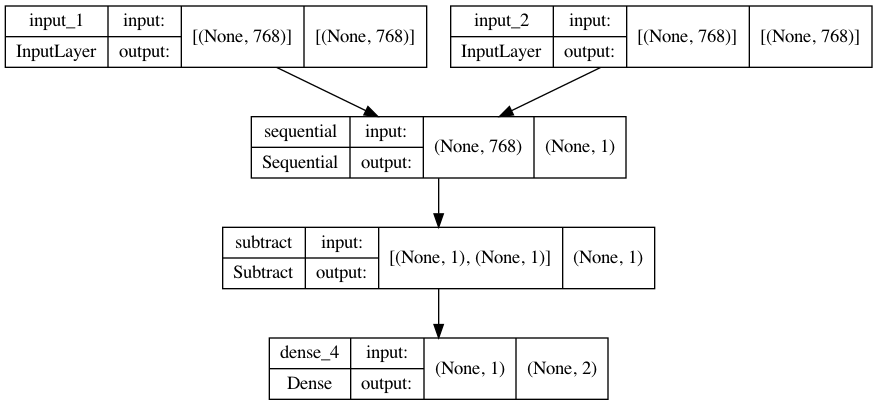

In [11]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [12]:
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer)

history = model.fit([inp1, inp2], y, epochs = n_epochs, shuffle = True, batch_size=batch_size, 
                    validation_split = 0.2, verbose=1)

Epoch 1/100
42/42 [==============================] - 1s 6ms/step - loss: 0.9202 - val_loss: 0.7494
Epoch 2/100
42/42 [==============================] - 0s 3ms/step - loss: 0.8670 - val_loss: 0.7631
Epoch 3/100
42/42 [==============================] - 0s 2ms/step - loss: 0.8612 - val_loss: 0.7788
Epoch 4/100
42/42 [==============================] - 0s 3ms/step - loss: 0.8559 - val_loss: 0.8055
Epoch 5/100
42/42 [==============================] - 0s 2ms/step - loss: 0.8233 - val_loss: 0.8336
Epoch 6/100
42/42 [==============================] - 0s 2ms/step - loss: 0.8121 - val_loss: 0.8580
Epoch 7/100
42/42 [==============================] - 0s 2ms/step - loss: 0.8011 - val_loss: 0.8760
Epoch 8/100
42/42 [==============================] - 0s 2ms/step - loss: 0.7994 - val_loss: 0.8811
Epoch 9/100
42/42 [==============================] - 0s 2ms/step - loss: 0.8070 - val_loss: 0.8849
Epoch 10/100
42/42 [==============================] - 0s 2ms/step - loss: 0.7990 - val_loss: 0.8802
Epoch 11/

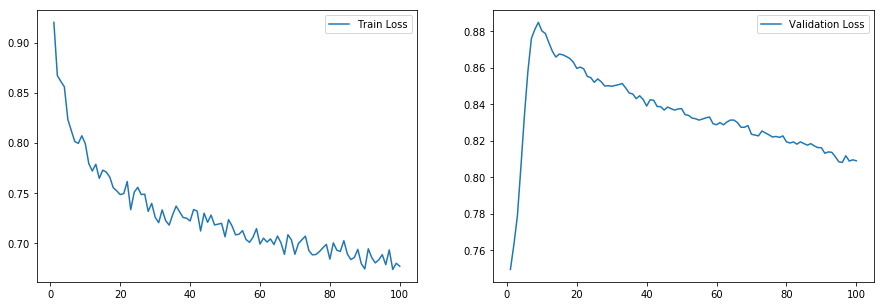

In [13]:
def plotting(train_loss, val_loss):
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.plot(range(1, n_epochs+1), train_loss, label = 'Train Loss')
    plt.legend()
    
    plt.subplot(122)
    plt.plot(range(1, n_epochs+1), val_loss, label = 'Validation Loss')
    plt.legend()

train_loss = history.history['loss']
val_loss = history.history['val_loss']
plotting(train_loss, val_loss)  

### Pointwise LTR

In this method, since we are given relevance levels explicitly, we can model this as classification task and predict relevance scores given query, document information.

In [14]:
sample_pct = 0.1
data = orig_data.groupby('relevance_level', group_keys = False).apply(lambda x: x.sample(frac = sample_pct))

train_df, val_df = train_test_split(data, stratify = data['relevance_level'], test_size=0.2, random_state=42)
len(train_df), len(val_df)

(8846, 2212)

In [15]:
train_df['query'] = train_df['query_id'].apply(lambda x: queries[x])
train_df['docs'] = train_df['doc_id'].apply(lambda x: docs[x])

val_df['query'] = val_df['query_id'].apply(lambda x: queries[x])
val_df['docs'] = val_df['doc_id'].apply(lambda x: docs[x])

In [16]:
def featurizer(train_df, val_df, label):
    vectorizer = TfidfVectorizer()
    train_vecs = vectorizer.fit_transform(train_df[label])
    val_vecs = vectorizer.transform(val_df[label])
    return train_vecs, val_vecs

train_query_vecs, val_query_vecs = featurizer(train_df, val_df, 'query')
train_doc_vecs, val_doc_vecs = featurizer(train_df, val_df, 'docs')

In [17]:
X_train = sp.hstack((train_query_vecs, train_doc_vecs))
X_val = sp.hstack((val_query_vecs, val_doc_vecs))
y_train = train_df['relevance_level'].astype('int').values
y_val = val_df['relevance_level'].astype('int').values

# relevance levels {1, 2} --> {0, 1}
y_train -= 1
y_val -= 1
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((8846, 79603), (8846,), (2212, 79603), (2212,))

In [18]:
X_train = X_train.toarray()
sparsity = np.sum(X_train==0) / (X_train.shape[0] * X_train.shape[1])
print('Sparsity:', sparsity)

Sparsity: 0.993874840727315


In [19]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)

accuracy_score(y_val, y_pred)

0.961121157323689